In [7]:
################################################ READ ME #################################################################

# There are 4 classes: Load(), Plot(), BLRS(), and ALS()

# Load() -- has the function to load the data
# Plot() -- has the functions to plot the data statistics 
# BLRS() -- implements the basic item-item collaborative filtering recommender system
# ALS()  -- implements the advanced recommender systems that uses alternating least squares 

# IMPORTANT: you must run the cells with the classes in order to view the results from the examples

##########################################################################################################################

# The cell under the Plot() class outputs the plots corresponding to the data
# The cell under the BLRS() class outputs examples showing that the functions in the class works
# The cell under the ALS() class outputs examples showing that the functions in the class works
# The last cell implements the evaluation system and outputs the resulsts

# TO USE THE FUNCTIONS: Read the comments and see the examples to enter the correct arguments for the functions

In [8]:
############################### RUN THIS CELL TO IMPORT THE LIBRARIES AND LOAD DATA ######################################

import numpy as np
import pandas as pd 
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import csv
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, issparse 
import scipy.sparse as sp
from random import sample

class Load: 
        # Load the data file
    def loadRatings(self, df):
        df = pd.read_csv(df,  sep=',', header=None)         
        df.columns = ['user_id', 'item_id', 'rating', 'timestamp']    # column labels
       
        return df

In [9]:
####################################### PLOTS FOR DATA ANALYSIS ##########################################################

class Plot:
            
    # Plot ratings with respect to items
    def plotRatingItems(self):
        dfPlot = pd.read_csv('ratings_Electronics_50.csv', header = None)
        dfPlot[1].value_counts().hist(bins=100, range=[1,30])
        plt.ylabel('Counts')
        plt.xlabel('#Ratings')
        plt.title('Ratings w.r.t. Items')
        plt.show()
    
    # plot ratings with respect to users
    def plotRatingUsers(self):
        dfPlot = pd.read_csv('ratings_Electronics_50.csv', header = None)
        dfPlot[0].value_counts().hist(bins=500)
        plt.ylabel('Counts')
        plt.xlabel('#Ratings')
        plt.title('Ratings w.r.t. Users')
        plt.show()
    
    # Calculate the minimum, maximum, median, average number and standard deviation of ratings per user and per item
    # Show the results for users and items in a boxplot
    # To see the numerical values uncomment the print statements
    def boxPlot(self, df):
        #print('The minimun rating for each user is:')
        dfMinUser = df.groupby(['user_id'])['rating'].min()
        #print(dfMinUser)
        #print('The minimun rating for each item is:')
        dfMinItem = df.groupby(['item_id'])['rating'].min()
        #print(dfMinItem)
        #print('The maximum rating for each user is:')
        dfMaxUser = df.groupby(['user_id'])['rating'].max()
        #print(dfMaxUser)
        #print('The maximum rating for each item is:')
        dfMaxItem = df.groupby(['item_id'])['rating'].min()
        #print(dfMaxItem)
        #print('The median rating for each user is:')
        dfMedUser = df.groupby(['user_id'])['rating'].median()
        #print(dfMedUser)
        #print('The median rating for each item is:')
        dfMedItem = df.groupby(['item_id'])['rating'].median()
        #print(dfMedItem)
        #print('The average of rating for each user is:')
        dfAvgUser = df.groupby(['user_id'])['rating'].mean()
        #print(dfAvgUser)
        #print('The average of rating for each item is:')
        dfAvgItem = df.groupby(['item_id'])['rating'].mean()
        #print(dfAvgItem)
        #print('The standart deviation of rating for each user is:')
        dfStdUser = df.groupby(['user_id'])['rating'].std()
        #print(dfStdUser)
        #print('The standart deviation of rating for each item is:')
        dfStdItem = df.groupby(['item_id'])['rating'].std()
        #print(dfStdItem)
        
        #Show the results for users in a boxplot
        #Create a new dataframe that contains the min, max, med, avg and std for each user as calculated in the previous question
        userDataFrame = pd.DataFrame(
            {
             'min': dfMinUser,
             'max': dfMaxUser,
             'med': dfMaxUser,
             'avg': dfAvgUser,
             'std': dfStdUser
            })

        userDataFrame.boxplot()
        plt.title('Boxplot for Users Statistics')
        plt.show()
        
        #Show the results for items in a boxplot
        #Create a new dataframe that contains the min, max, med, avg and std for each item as calculated in the previous question
        itemDataFrame = pd.DataFrame(
            {
             'min': dfMinItem,
             'max': dfMaxItem,
             'med': dfMaxItem,
             'avg': dfAvgItem,
             'std': dfStdItem
            })

        itemDataFrame.boxplot()
        plt.title('Boxplot for Items Statistics')
        plt.show()

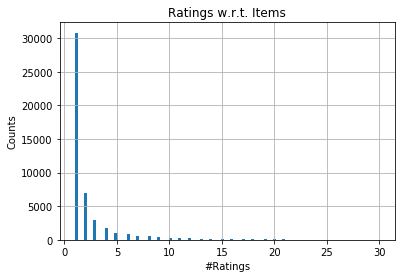

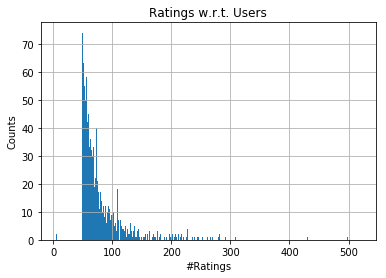

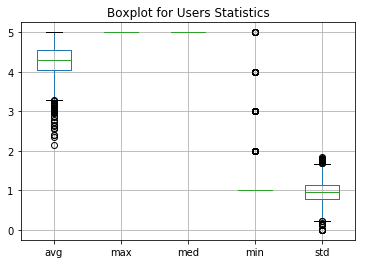

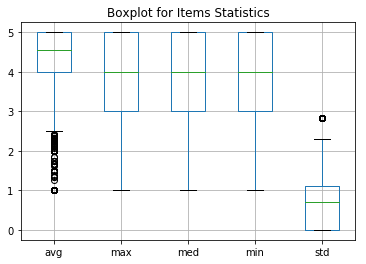

In [10]:
#################################################### PLOTS EXAMPLE #######################################################

# Call Load class
l = Load()
# load the data
df = l.loadRatings('ratings_Electronics_50.csv')

# Call Plot class
p = Plot()

# Plot of ratings w.r.t. items
p.plotRatingItems()
# Plot of ratings w.r.t. users
p.plotRatingUsers()
# Box plot
p.boxPlot(df)

In [11]:
############################ THIS CELL CONTAINS THE CODE FOR THE BLRS RECOMMENDER SYSTEM ################################
############################ AND THE FUNCTION TO COMPUTE THE SPARSITY OF THE DATA #######################################

# Implement a basic Item-to-Item Collaborative Filtering Recommender System
class BLRS:
    
    # Call this function to see the number of users and items in the data
    def get_users_items(self, df):     
        users_items = df.groupby(by=['user_id','item_id']).apply(lambda x: 1).to_dict() 
        n_users = df.user_id.unique().shape[0]
        n_items = df.item_id.unique().shape[0]
        
        print('Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items))

    # Construct the rating matrix from data
    def buildRatingM(self, df):
         
        users_items = df.groupby(by=['user_id','item_id']).apply(lambda x: 1).to_dict() 
        self.n_users = df.user_id.unique().shape[0]
        self.n_items = df.item_id.unique().shape[0]

        # Build Rating matrix
        row, col = zip(*(users_items.keys())) #row-> users,  col-> items
        self.map_u = dict(zip(df['user_id'].unique(),range(self.n_users)))     # user dict: keys are the userID and values are the indexes
        self.map_i = dict(zip(df['item_id'].unique(),range(self.n_items)))     # item dict: keys are the itemID and values are the indexes
        row_idx = [self.map_u[u] for u in row]
        col_idx = [self.map_i[i] for i in col]
        ratings = df['rating'].tolist()
        data = np.array(ratings, dtype=np.float32)
        # Create the rating matrix where the rows corresponds the users and the columns corresponds the items
        # the values of the matrix are the ratings with respect to users and items
        ratingM = csr_matrix((data, (row_idx, col_idx)), shape=(self.n_users,self.n_items))   
        
        return ratingM
    
    # Get the average rating per user
    def avgR(self, df):
        
        # Get the rating matrix
        ratingM = self.buildRatingM(df)
        
        tot = np.array(ratingM.sum(axis=1).squeeze())[0]    # Sum of ratings
        cts = np.diff(ratingM.indptr)    # Total number of non-zero ratings
        mu = tot/cts    # Average rating per user
        
        # Returns an array of the average ratings per user 
        # where the indexes corresponds to the user index in the rating matrix
        return mu   
    
    # Computes the similiarity matrix
    def simM(self, df):
        
        # Get the rating matrix
        ratingM = self.buildRatingM(df)
        
        # Get the average rating per user
        mu = self.avgR(df)

        # Construct mean-adjusted matrix
        # When subtract the rating matrix by the matrix of mu
        # the unknown rating which is represented as zero is not subtracted 
        # Make sure the rating doesn’t become a negative number but remains zero instead
        d = sp.diags(mu, 0)
        d = d.todense()
        b = ratingM.copy()
        b.data = np.ones_like(b.data)
        b = b.todense()

        mean_adjusted = ratingM - d*b

        # Construct similarity matrix
        sim_matrix = 1 -squareform(pdist(mean_adjusted.T, 'cosine'))
        
        # For items with only ratings of 0, the denominator will be 0
        # the division by the norm will result in NaN.
        # We change the NaN values to 0 for sorting purposes in the rating prediction step
        sim_matrix[np.isnan(sim_matrix)] = 0
        
        return sim_matrix
    
    # Computes the sparsity of the rating matrix
    def sparsity(self):
        
        # Get rating matrix
        ratingM = self.buildRatingM(df)
        ratingM_array = ratingM.toarray()
        
        # Get the unique counts of ratings (0 to 5: 0 meaning an unrated item)
        unique, counts = np.unique(ratingM_array, return_counts=True)
        # Get the number of unrated items
        unknown_ratings = counts[0]
        unknown_ratings = float(unknown_ratings)
        # Compute the sparsity of the matrix
        sparsity = (unknown_ratings/(self.n_users*self.n_items))*100
        sparsity = float(str(round(sparsity, 2)))

        print("The Sparsity of the Rating Matrix is: " + str(sparsity) + "%")
        

    # Predict the rating given a user and item        
    def predictRating(self, userID, itemID, df): 
        
        # Get rating matrix
        ratingM = self.buildRatingM(df)
        ratingM_array = ratingM.toarray()
        
        # Get similarity matrix
        sim_matrix = self.simM(df)

        user_idx = self.map_u.get(userID)  # Get the row corresponding to the user
        item_idx = self.map_i.get(itemID)  # Get the col corresponding to item

        if ratingM_array[user_idx, item_idx] != 0:  # If the given user rated the given item
            print("The user has already rated this item!")
        else:
            v = sim_matrix[:,item_idx]   # Simalarity vector: get the column in the sim_matrix corresponding to the given item
            v = v[v >= 0]                # Disregard the similarities that are negative
            item_num = np.argsort(v)     # Sort the index of the similarity vector
            item_num = item_num[::-1]    # Descending order
            item_num = item_num[1:51]    # For L = 50 : Pick the most similar 50 items 
                                         # Disregard the first element because the similarity is 1: the item compared to itself
            v = sorted(v)                # Sort the similarity vector
            v = v[::-1]                  # Descending order
            v = v[1:51]                  # For L = 50: Pick the most similar 50 items

            item_rating = []

            for k in range(0,50):
                item_rating.append(ratingM_array[user_idx, item_num[k]])    # list of ratings corresponding to the 50 most similar items

            dot_p = np.dot(v, item_rating)     # Compute the dot product of the similarities of items and the item ratings
            sim_sum = sum(np.absolute(v))      # Absolute value of the sum of similarities
            pred = dot_p/sim_sum               # Compute the prediction for the given item
            
            pred = float(str(round(pred, 2)))  # Round the rating

            print('The predicted rating of user: ' + str(userID) + ' for item: ' + str(itemID) + ' is ' + str(pred))
            
    # Given a user compute the top K recommendations provided by the predicted ratings
    def predictTopKRecommendations(self, userID, k, df):
        
        # Get rating matrix
        ratingM = self.buildRatingM(df)
        ratingM_array = ratingM.toarray()
        
        # Get sim matrix
        sim_matrix = self.simM(df)
        
        
        user_idx = self.map_u.get(userID)      # Get row index of user
        unrated_items = []
        

        user_row = ratingM_array[user_idx,:]  # Get the ratings of given user

        user_row = user_row.astype(int)   # Convert ratings to integer

        for i in range(len(user_row)):    
            if user_row[i] == 0:
                unrated_items.append(i)   # Vector of the index of the unrated items

        v = []
        item_idx = []
        w =[]


        for i in unrated_items:
            v.append(sim_matrix[:,i])     # Get the ratings from the sim_matrix with the index of unrated items
            
        # Disregard negative similarities
        for i in range(len(v)):
            v[i] = v[i][v[i] >= 0] 

        for i in range(len(v)):
            item_idx.append(v[i].argsort()[::-1][:51])    # For L = 50, get 50 most similar items and sort the similarities by index
            w.append(sorted(v[i], reverse=True)[:51])     # Sort similarities, get 50 most similar items

        item_idx = np.delete(item_idx, [0], axis=1)       # Delete the first element of the vector where the similarity is compared with the item itself
        w = np.delete(w, [0], axis=1)

        item_ratings = []

        for i in range(len(item_idx)):
            item_ratings.append([])
            for j in range(0,50):
                item_ratings[i].append(ratingM_array[user_idx, item_idx[i][j]])   # Get the ratings of the most similar items by the user        

        dot_p = []
        sim_sum = []   

        for i in range(len(item_idx)):
            dot_p.append(np.dot(w[i], item_ratings[i]))   # Compute dot product
            sim_sum.append(sum(w[i]))                     # Compute sum of similarities

        dot_p = np.array(dot_p)
        sim_sum = np.array(sim_sum)  


        pred = dot_p/sim_sum                              # Compute predictions

        pred[np.isnan(pred)] = 0                          # Change NaN predictions to zero
        
    
        for i in range(len(item_idx)):
            pred[i] = float(str(round(pred[i], 2)))       # Round predicitons

        pred = np.array(pred)

        result = np.vstack((unrated_items, pred))         # Contrust a matrix where the 1st row is the unrated items 
                                                          # and the 2nd row is the predictions corresponding to the unrated items

        result = result[:,result[1,:].argsort()[::-1]]    # Sort the predictions in desc. order

        u_i = result[0,:]                                 # Vector of unrated items after sorting
        u_i = u_i.astype(int)

        # Get the item labels from dict for the unrated items 
        item_list = []
        for i in range(len(u_i)):
            for key, value in self.map_i.items():
                if value == u_i[i]:
                    it = key
                    item_list.append(it)

        u_pred = result[1,:]                              # Vector of predictions after sorting

        
        i_list = []
        p_list =[]

        for i in range(0,k):
            i_list.append(item_list[i])    # List of top k recommendation items
            p_list.append(u_pred[i])       # List of predictions with respect to the top k recommendation items
        
        return (i_list, p_list)
    
    # Print the top k recommendations for a given user    
    def printTopK(self, userID, k, df):
        
        # Get the top k recommendation items and their predicted ratings
        item_rating = self.predictTopKRecommendations(userID, k, df)
        
        print('Top ' + str(k) + ' recommendations for user ' + str(userID) + ' : ')
        print(" ")

        for i in range(0,k):
            
            print(str(i+1) + '. Item ' + str(item_rating[0][i]) + ' with Predicated Rating of ' + str(item_rating[1][i]))
            
    # Compute the number of relavent items for each user         
    def revItems(self, userID, k, df):
        
        # Get the average ratings for all users
        mu = self.avgR(df)
    
        # Get row index of user
        user_idx = self.map_u.get(userID)      
        
        # Get the average rating for the given user
        avg_rating = mu[user_idx]
        
        # Get the top 10 items
        item_rating = self.predictTopKRecommendations(userID, k, df)    
        
        rev_items = []
        
        for i in range(0, k):
            # If the predicted rating of an item is greater than the average rating of the user
            if np.any(item_rating[1][i] > mu):
                # Add it to the list of relavent items
                rev_items.append(i)
 
        # Get the number of relavent items in the list
        num_rev = len(rev_items)
        
        return(num_rev)
    
    # Compute Precision M = 10:       
    def precision(self, users, M, df):
        
        # Get the number of users
        
        num_users = len(users)
        
        num_users = float(num_users)
        
        num_rev = []
        
        # Get the number of relavent items for each user
        for i in range(len(users)):
            num_rev.append(self.revItems(users[i], M, df))
        
        # Divide the number of relavent items of each user by M = 10
        a = [i/M for i in num_rev]
        # Sum the result for all users
        sum_rev = sum(a)
        # Compute the precision, M = 10 
        prec = (1/(num_users)) * sum_rev
        prec = float(str(round(prec, 2)))
        
        # Print result
        print('Precision@10 for BLRS is ' + str(prec))

In [12]:
####################################### EXAMPLES OF THE RESULTS OF RUNNING BLRS ##########################################

# Call Load class
l = Load()
# Load the data by inserting the name of the file (ex:'ratings_Electronics_50.csv')
df = l.loadRatings('ratings_Electronics_50.csv')

# Call the BLRS class
d = BLRS()

# Get the rating matrix by calling the function buildRatingM
# The arugument is the data (ex: df)
rating_matrix = d.buildRatingM(df).toarray()
print("\n ---------------------------------------------------------------------------- \n")
print("The rating matrix: \n")
print(rating_matrix)

# Get the number of users and items of the data (df)
print("\n ---------------------------------------------------------------------------- \n")
d.get_users_items(df)
print("\n ---------------------------------------------------------------------------- \n")


# Get the sparsity of the data
d.sparsity()
print("\n ---------------------------------------------------------------------------- \n")

# For the purpose of faster computation time, we reduced the data to the first 5000 rows
df = df[:5000]

print("BLRS RECOMMENDER SYSTEM RESULTS:")
print(" ")
# Get the similarity matrix by calling the function simM
# The arugument is the  data (ex: df)
sim_mat = d.simM(df)
print("The similarity matrix: \n")
print(sim_mat)

print("\n ---------------------------------------------------------------------------- \n")
####################################### Examples of results of the predictRating function ################################

# Get the predicted ratings
# The first argument is the userID (ex: 'A12LH2100CKQO)
# The second argument is the itemID (ex: 'B000OFSN4G')
# The last arguement is the data (ex: df)
d.predictRating('A28I5UM0FT3I6T','B000OFSN4G', df)
# Example of the result when the user has already rated the item
print(" ")
d.predictRating('A12LH2100CKQO','B0002AOQ9O', df)
print("\n ---------------------------------------------------------------------------- \n")


############################### Example of the result of the top k recommendations for a given user ######################

# The first argument is the userID (ex: 'A12LH2100CKQO')
# The second argument is k (ex: top 5)
# The third arguement is the data (ex: df)
d.printTopK('A28I5UM0FT3I6T', 5, df)
print("\n ---------------------------------------------------------------------------- \n")

##########################################################################################################################

# Get the number of relavent items for a given user

r = d.revItems('A28I5UM0FT3I6T', 5, df)
print("The number of relavent items for userID A28I5UM0FT3I6T is: " + str(r))
print("\n ---------------------------------------------------------------------------- \n")


 ---------------------------------------------------------------------------- 

The rating matrix: 

[[5. 5. 5. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 5. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 ---------------------------------------------------------------------------- 

Number of users = 1542 | Number of items = 48190

 ---------------------------------------------------------------------------- 

The Sparsity of the Rating Matrix is: 99.83%

 ---------------------------------------------------------------------------- 

BLRS RECOMMENDER SYSTEM RESULTS:
 
The similarity matrix: 

[[ 1.  1.  1. ...  0.  0.  0.]
 [ 1.  1.  1. ...  0.  0.  0.]
 [ 1.  1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  1. -1.]
 [ 0.  0.  0. ...  1.  1. -1.]
 [ 0.  0.  0. ... -1. -1.  1.]]

 ---------------------------------------------------------------------------- 

The predicted rating of user: A28I5UM0FT3I6T for item: B000OFSN4G is 3.2

In [13]:
################################## THIS CELL CONTAINS THE CODE FOR THE ALS RECOMMENDER SYSTEM ############################

class ALS():

    # Construct the rating matrix from data
    def buildRatingM(self, df):
         
        users_items = df.groupby(by=['user_id','item_id']).apply(lambda x: 1).to_dict() 
        self.n_users = df.user_id.unique().shape[0]
        self.n_items = df.item_id.unique().shape[0]

        # Build Rating matrix
        row, col = zip(*(users_items.keys())) #row-> users,  col-> items
        self.map_u = dict(zip(df['user_id'].unique(),range(self.n_users)))     # user dict: keys are the userID and values are the indexes
        self.map_i = dict(zip(df['item_id'].unique(),range(self.n_items)))     # item dict: keys are the itemID and values are the indexes
        row_idx = [self.map_u[u] for u in row]
        col_idx = [self.map_i[i] for i in col]
        ratings = df['rating'].tolist()
        data = np.array(ratings, dtype=np.float32)
        # Create the rating matrix where the rows corresponds the users and the columns corresponds the items
        # the values of the matrix are the ratings with respect to users and items
        ratingM = csr_matrix((data, (row_idx, col_idx)), shape=(self.n_users,self.n_items))   
        
        return ratingM
    
    # Get the average rating per user
    def avgR(self, df):
        
        # Get the rating matrix
        ratingM = self.buildRatingM(df)
        
        tot = np.array(ratingM.sum(axis=1).squeeze())[0]    # Sum of ratings
        cts = np.diff(ratingM.indptr)    # Total number of non-zero ratings
        mu = tot/cts    # Average rating per user
        
        # Returns an array of the average ratings per user 
        # where the indexes corresponds to the user index in the rating matrix
        return mu   

    #A function that implements AlS algorithm with U-V matrix decompositon
    def runALS(self, df): 
        Q = self.buildRatingM(df) #User-Item Matrix with ratings 
        Q = Q.toarray()
        #Replace the items that are rated with a 1 and the items that are not rated with 0, so that we have a binary matrix
        W = Q>0.5
        # User-Item Matrix with 1 if there is a rating or 0 if not
        W[W == True] = 1
        W[W == False] = 0
        # To be consistent with our Q matrix
        W = W.astype(np.float64, copy=False)
    
        
        #The implementation of the AlS algorithm with U-V matrix decompositon
        #In order to observe how each parameter works and how it influences the result of the algorithm we calculate the MSE.
        #We print it after each iteration so that we see if the error decreases and after what point it start to encrease or
        #not change anymore so that we can stop the iterations. To help the visualisaton we also plot the error.
        lambdA = 0.1 #Regularization parameter
        nFactors = 3 #How many factors each of user and item matrix will consider
        n, m = Q.shape
        nIterations = 20 #How many times to run algorithm
        #Iitialize the user and item vectors with random values
        Users = 5 * np.random.rand(n, nFactors)
        Items = 5 * np.random.rand(nFactors, m)
        
        #print( "Initiating ")

        # A function to calculate the MSE
        def get_error(Q, Users, Items, W):
             # This calculates the MSE of nonzero elements
            return np.sum((W * (Q - np.dot(Users, Items))) ** 2) / np.sum(W)

    #Initialise the list of errors to be printed at the end for observational reasons
        MSE_List = []
    #Running the iterations for the ALS algorithm
        #print ("Starting Iterations")
        #The iteration steps of the ALS algorithm with respect to users and items 
        for iter in range(nIterations):
            for i, Ri in enumerate(W):
                Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambdA * np.eye(nFactors), np.dot(Items, np.dot(np.diag(Ri), Q[i].T))).T
            #print ("Error after solving for User Matrix:", get_error(Q, Users, Items, W))

            for j, Rj in enumerate(W.T):
                Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambdA * np.eye(nFactors), np.dot(Users.T, np.dot(np.diag(Rj), Q[:, j])))
            #print ("Error after solving for Item Matrix:", get_error(Q, Users, Items, W))

            MSE_List.append(get_error(Q, Users, Items, W))
            #print ('%sth iteration is complete...' % iter)

        #print (MSE_List)
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111)
    #     plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    #     plt.title('Python Implementation MSE by Iteration \n with %d users and %d items' % Q.shape);
    #     #plt.savefig('Python MSE Graph.pdf', format='pdf')
        #plt.show()

    #Calculating the prediction matrix as the dot product of the Users and Items arrays 
        PMatrix = np.dot(Users, Items)
        
        return PMatrix

    # Given an user and item, compute the predicted rating for the item
    def predictRatingALS(self, u, i, df):
        
        # Get rating matrix
        matrix = self.buildRatingM(df)
        
        # Get prediction matrix
        pred_matrix = self.runALS(df)

        u_idx = self.map_u.get(u)  # Get the row corresponding to the user
        i_idx = self.map_i.get(i)  # Get the col corresponding to item

        # If the user has already rated the item
        if matrix[u_idx, i_idx] !=0:
            print("User rated this item already!")
        else:
            # Get the predicted rating from the prediction matrix
            pred = pred_matrix[u_idx, i_idx]
            pred = float(str(round(pred, 2)))

            print('The predicted rating of user: ' + str(u) + ' for item: ' + str(i) + ' is ' + str(pred))

    # Get the top k items recommended to a user 
    def predictTopKRecommendationsALS(self, u, k, df):
        
        # Get rating matrix
        ratingM = self.buildRatingM(df)     
        ratingM_array = ratingM.toarray()
        
        # Get predicition matrix
        predMatrix = self.runALS(df)
        
        # get the
        u_idx = self.map_u.get(u)

        unrated_items = []
        
        # Get the unrated items
        for i in range(ratingM_array.shape[1]):
            if ratingM_array[u_idx, i] == 0:
                unrated_items.append(i)    # item idx

        item_pred = []

        # Get the predicted ratings for the unrated items
        for i in range(len(unrated_items)):
            item_pred.append(predMatrix[u_idx, i])

        # Construct a matrix where the 1st row is the unrated items 
        # and the 2nd row is the predictions corresponding to the unrated items
        result = np.vstack((unrated_items, item_pred))        
        result = result[:,result[1,:].argsort()[::-1]]    # Sort the predictions in desc. order

        # Vector of unrated items after sorting
        u_i = result[0,:]                                 
        u_i = u_i.astype(int)

        # Vector of predictions after sorting
        u_pred = result[1,:]                              

        for i in range(len(u_pred)):
            u_pred[i] = float(str(round(u_pred[i], 2))) 

        item_list = []

        # Get the itemID for the items
        for i in range(len(u_i)):
            for key, value in self.map_i.items():
                if value == u_i[i]:
                    it = key
                    item_list.append(it)
        
        i_list = []
        p_list =[]
        
        for i in range(0,k):
            
            i_list.append(item_list[i])    # List of top k items
            p_list.append(u_pred[i])       # List of corresponding predicted ratings
        
        return (i_list, p_list)
        
    # Print the top k recommendations given a user
    def printTopKALS(self, userID, k, df):
        
        # Get the top k items and predicted ratings
        item_rating = self. predictTopKRecommendationsALS(userID, k, df)
        
        
        print('Top ' + str(k) + ' recommendations for user ' + str(userID) + ' : ')
        print(" ")
        
        for i in range(0,k):
            print(str(i+1) + '. Item ' + str(item_rating[0][i]) + ' with Predicated Rating of ' + str(item_rating[1][i]))
         
    # Get the number of relavent items per user    
    def revItemsALS(self, userID, k, df):
        
        # Get the average rating of all users
        mu = self.avgR(df)
        
        # Get row index of user
        user_idx = self.map_u.get(userID)      
        
        # Get the average rating of the given user
        avg_rating = mu[user_idx]
        
        # Compute the top k recommendations for the given user
        item_rating = self.predictTopKRecommendationsALS(userID, k, df)    
        
        rev_items = []
    
        # If the predicted rating is greater than the average rating of the user add it to a list
        for i in range(0, k):
            if np.any(item_rating[1][i] > mu):
                rev_items.append(i)
                
        # Get the number of relavent items in the list        
        num_rev = len(rev_items)
        
        return(num_rev)
         
    #Precision M = 10, top 10 items
    def precisionALS(self, users, M, df):
        
        # Get the number of users in the data
        num_users = len(users)
        
        num_users = float(num_users)
        
        num_rev = []

        # Get the number of relavent items for each user
        for i in range(len(users)):
            num_rev.append(self.revItemsALS(users[i], M, df))
            
        # Divide the number of relavent items for each user by M = 10
        a = [i/M for i in num_rev]
        # Sum the result
        sum_rev = sum(a)
        
        # Compute the precision
        prec = (1/(num_users)) * sum_rev
        prec = float(str(round(prec, 2)))
        
        print('Precision@10 for ALS is ' + str(prec))      

In [14]:
######################################### EXAMPLES OF THE RESULTS OF RUNNING ALS ########################################

# Call Load class
l = Load()
# Load the data by inserting the name of the file (ex:'ratings_Electronics_50.csv')
df = l.loadRatings('ratings_Electronics_50.csv')
# For the purpose of faster computation time, we reduced the data to the first 5000 rows
df = df[:5000]

# Call the BLRS class
a = ALS()

print("\n ---------------------------------------------------------------------------- \n")
print("ALS RECOMMENDER SYSTEM RESULTS:")
print(" ")
# Get the prediction matrix with the predicted ratings
# The argument is the data (ex: df)
pred_matrix = a.runALS(df)
print("The prediction matrix: \n")
print(pred_matrix)
print("\n ---------------------------------------------------------------------------- \n")


################################### Examples of results of the predictRatingALS function ################################

# Get the predicted ratings
# The first argument is the userID (ex: 'A12LH2100CKQO)
# The second argument is the itemID (ex: 'B00008A6CC')
# The last arguement is the data (ex: df)
a.predictRatingALS('A28I5UM0FT3I6T','B000OFSN4G', df)
# Example of the result when the user has already rated the item
print(" ")
a.predictRatingALS('A12LH2100CKQO','B0002AOQ9O', df)
print("\n ---------------------------------------------------------------------------- \n")


############################### Example of the result of the top k recommendations for a given user ######################

# The first argument is the userID (ex: 'A12LH2100CKQO')
# The second argument is k (ex: top 5)
# The third arguement is the data (ex: df)
a.printTopKALS('A1ZVFCPHCWFV71', 5, df)
print("\n ---------------------------------------------------------------------------- \n")

##########################################################################################################################

# Get the number of relavent items for a given user

r = a.revItemsALS('A12LH2100CKQO', 5, df)
print("The number of relavent items for userID A28I5UM0FT3I6T is: " + str(r))
print("\n ---------------------------------------------------------------------------- \n")


 ---------------------------------------------------------------------------- 

ALS RECOMMENDER SYSTEM RESULTS:
 
The prediction matrix: 

[[ 2.93763344  3.91684458  1.95842229 ...  0.11955581  0.47822323
   0.59777903]
 [ 1.39335638  1.8578085   0.92890425 ...  0.93286444  3.73145777
   4.66432221]
 [ 0.1079477   0.14393027  0.07196514 ...  0.96514505  3.8605802
   4.82572526]
 ...
 [ 1.45615052  1.94153402  0.97076701 ...  0.8384589   3.3538356
   4.19229451]
 [ 2.62742169  3.50322892  1.75161446 ... -0.12975131 -0.51900522
  -0.64875653]
 [ 0.35504667  0.47339556  0.23669778 ...  0.97899914  3.91599657
   4.89499571]]

 ---------------------------------------------------------------------------- 

The predicted rating of user: A28I5UM0FT3I6T for item: B000OFSN4G is -0.5
 
User rated this item already!

 ---------------------------------------------------------------------------- 

Top 5 recommendations for user A1ZVFCPHCWFV71 : 
 
1. Item B00AVST4GM with Predicated Rating of 8.39
2

In [ ]:
####################################### EVALUATION SYSTEM (EvaS) RESULTS #################################################

# load folds 1 to 4
df1 = pd.read_csv('ratings_Electronics_50_fold1.csv', sep=',', header=None)
df2 = pd.read_csv('ratings_Electronics_50_fold2.csv', sep=',', header=None)
df3 = pd.read_csv('ratings_Electronics_50_fold3.csv', sep=',', header=None)
df4 = pd.read_csv('ratings_Electronics_50_fold4.csv', sep=',', header=None)
frames = [df1, df2, df3, df4]
# Combines the folds into training data
df_train = pd.concat(frames)
df_train.columns = ['user_id', 'item_id', 'rating', 'timestamp', 'fold']
# For the purpose of faster computation time, we reduced the data to the first 2000 rows
df_train = df_train[:2000]

# load fold 5 into test data
df_test = pd.read_csv('ratings_Electronics_50_fold5.csv', sep=',', header=None)
df_test.columns = ['user_id', 'item_id', 'rating', 'timestamp', 'fold']

# Find the users that appear in both the training and test data
df_user_train = df_train['user_id']
df_user_train = df_user_train.drop_duplicates()
df_user_test = df_test['user_id']
df_user_test = df_user_test.drop_duplicates()
f = [df_user_train, df_user_test]

users = pd.concat(f)

# Find the duplicated users in both training and test data and store the results in a new dataframe
users = users[users.duplicated(keep=False)]

# create random index
rindex =  np.array(sample(range(len(users)), 10))

# get 10 random users from the datadrame users
users = users.iloc[rindex]
users = np.array(users)

########################################## EXAMPLES TO EVALUATE BLRS ####################################################

# Call BLRS class
b = BLRS()

print("\n ---------------------------------------------------------------------------- \n")
print("EvaS--BLRS Results: \n")

# Get the top 10 recommendations for each of the 10 random users
for i in range(len(users)):
    b.printTopK(users[i], 10, df_train)
    print(" ")
    
print("\n ---------------------------------------------------------------------------- \n")
# Get precision@10 for the BLRS   
b.precision(users, 10, df_train)

########################################## EXAMPLES TO EVALUATE ALS ####################################################

# Call ALS class

a = ALS()

print("\n ---------------------------------------------------------------------------- \n")
print("EvaS--ALS Results: \n")

# Get the top 10 recommendations for each of the 10 random users
for i in range(len(users)):
    a.printTopKALS(users[i], 10, df_train)
    print(" ")
    
print("\n ---------------------------------------------------------------------------- \n")
# Get precision@10 for the ALS   
a.precisionALS(users, 10, df_train)



      